1. Token level perplexity in training set |

In [ ]:
# load gpt2 model to test first
from model import GPT 
import tiktoken 

enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

from src.etoken import ETokenizer

# Special tokenizer
etok = ETokenizer()

# Initialize vocab with GPT2 tokenizer from tiktoken object 'enc'
special_tokens = enc.__dict__['_special_tokens']
mergeable_ranks = enc.__dict__['_mergeable_ranks']
etok.special_tokens = special_tokens
etok.vocab = {idx: bytes([idx]) for idx in range(256)}
for s, idx in mergeable_ranks.items():
    etok.vocab[idx] = s
    
encode = lambda s: etok.encode(s)
decode = lambda l: etok.decode(l)

sgpt2 = GPT.from_pretrained('gpt2')

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True


In [2]:
# enc._special_tokens
text = "DeepSeek's architectural innovations (MoE, MLA, MTP, and FP8 Quantization) focus on optimizing large-scale training and deployment and serving efficiency. Not single-user or local runtime performance, e.g., MoE requires the same memory footprint as the Dense model despite using fewer parameters per inference, MTP's parallel token generation mainly benefits high-throughput scenarios."

import torch 
from src.utils import calculate_bits_per_char

token_ids = torch.tensor(encode(text)).view(1, -1)
input_ids, target_ids = token_ids[:, :-1], token_ids[:, 1:]
logits, token_loss = gpt2(input_ids, targets=target_ids, reduction='none') # loss is provided as an 'average' loss per token --- I want singular loss per token 
bpc_loss = calculate_bits_per_char(token_loss, target_ids, decode)

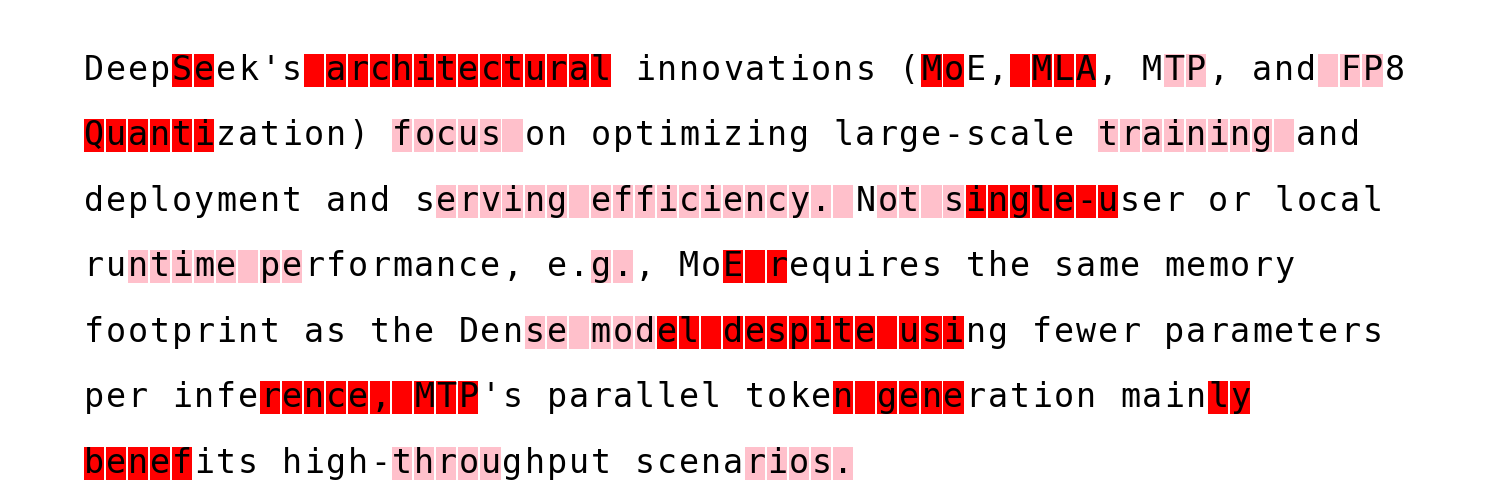

In [3]:
from src.vis import display_colored_text
from src.utils import shift_token_loss, map_token_to_char_perplexity, get_naive_char_color

token_perplexity = shift_token_loss(token_loss)
char_perplexity = map_token_to_char_perplexity(text, token_ids, token_perplexity, decode)
char_colors = get_naive_char_color(char_perplexity) # group in 60 quantile, 80 quantile for character coloring
display_colored_text(text, char_colors)

In [4]:
# Quantile threshold for logit loss values
quantile_threshold = 0.80
loss_threshold = torch.quantile(token_loss, 0.80)

# IDEA 1. Just to train a different tokenization base on the CharLM performance, and see if it improve performance
# ... Continuous morphing of tokenization scheme during training ...
# 'Merge tokens with similar embeddings'
# 'Spike in perplexity --> breaking token (if it's continuous)'
# 'Continuous Drop in perplexity --> merge tokens (if there are multiple tokens)'

# (a). Embedding similarity 
def detect_embedding_similarity(token_loss, quantile_threshold=0.80): 
    raise NotImplementedError

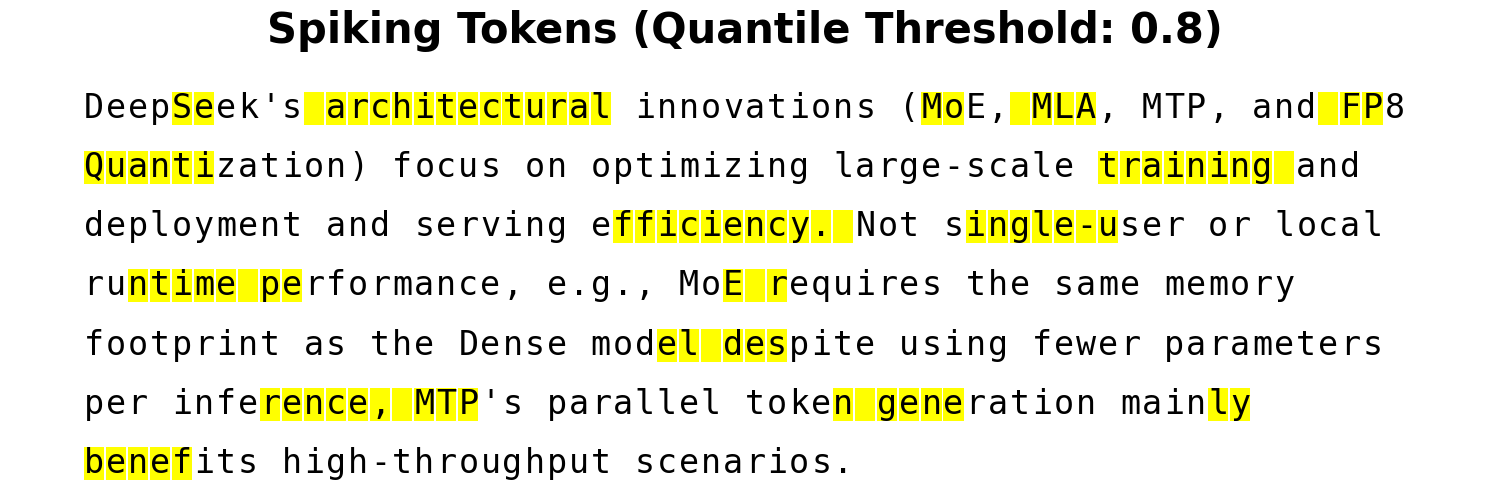

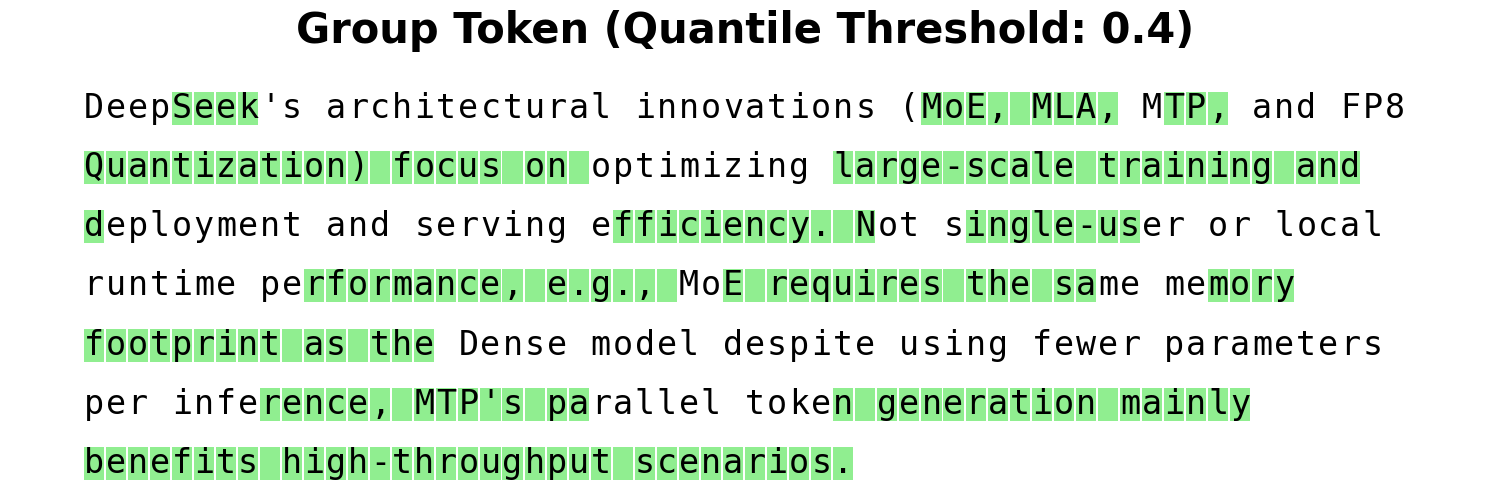

In [5]:
from src.grouping import get_spike_token_mask, get_group_token_mask

# (a). Spiking token visualization 
spike_quantile_threshold = 0.80
spike_token_mask = get_spike_token_mask(token_perplexity, quantile_threshold=spike_quantile_threshold)
char_perplexity, char_colors = map_token_to_char_perplexity(text, token_ids, token_perplexity, decode, spike_token_mask, mask_color='yellow')
display_colored_text(text, char_colors, title=f"Spiking Tokens (Quantile Threshold: {spike_quantile_threshold})")

# (b). Group token visualization 
group_quantile_threshold = 0.4
group_token_mask = get_group_token_mask(token_perplexity, quantile_threshold=group_quantile_threshold)
char_perplexity, char_colors = map_token_to_char_perplexity(text, token_ids, token_perplexity, decode, group_token_mask, mask_color='lightgreen')
display_colored_text(text, char_colors, title=f"Group Token (Quantile Threshold: {group_quantile_threshold})")

In [6]:
# Change tokenization scheme according to spike & group tokens 

from src.grouping import detect_group_token, detect_spike_token
import tiktoken 

# (a). Spike token 
tokens_to_split = detect_spike_token(token_ids, token_perplexity, quantile_threshold=spike_quantile_threshold)

# (b). Group token 
tokens_to_group = detect_group_token(token_ids, token_perplexity, quantile_threshold=group_quantile_threshold)

# (c). Special tokenizer class allowing for : 
#    - 1. custom initialization 
#    - 2. cutom token merging 
#    - 3. custom token splitting

# (d). Dynamically training LLM with tokenizer update 

In [7]:
from src.etoken import ETokenizer

etok = ETokenizer()

# add new token into the vocabulary 
tokens_to_group

# remove 'split token' from the vocabulary (assuming sub-token exists, so split token should have longer length than 1)
tokens_to_split

[4653,
 27070,
 16632,
 43265,
 31459,
 16972,
 3047,
 9332,
 2060,
 19124,
 4270,
 2746,
 32278,
 11241,
 8384]

In [25]:



            
# Update vocab with spike / merge tokens 
etok.add_tokens(tokens_to_group) # works now 

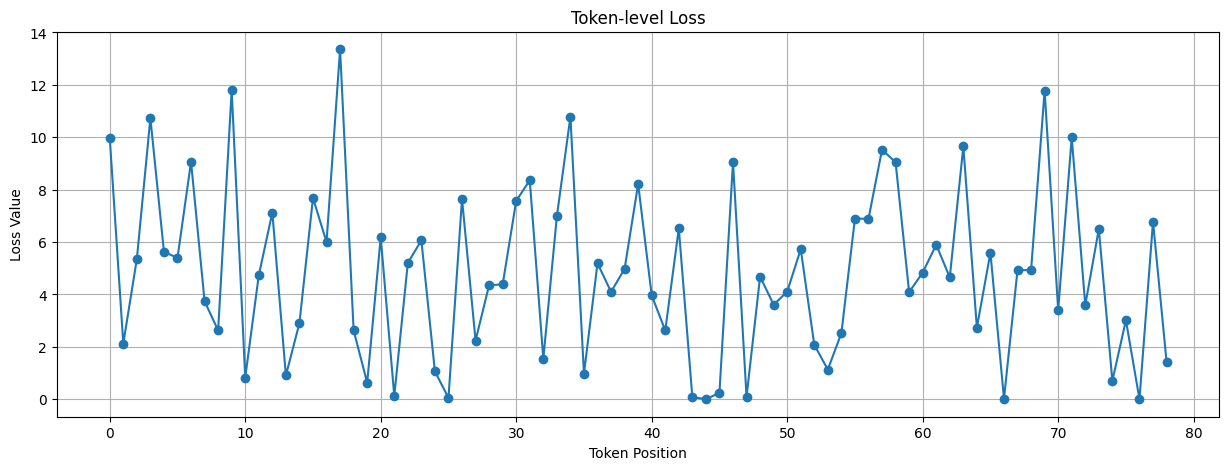


Tokens with highest loss:
1. Loss: 13.36, Token: ' Quant'
2. Loss: 11.80, Token: ' MLA'
3. Loss: 11.78, Token: ' token'
4. Loss: 10.78, Token: ' single'
5. Loss: 10.73, Token: ' architectural'


In [8]:

# do a plot of the token-level loss
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(token_loss.detach().numpy(), marker='o')
plt.title('Token-level Loss')
plt.xlabel('Token Position') 
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()

# Print tokens with highest loss
top_k = 5
top_losses = torch.topk(token_loss, k=top_k)
print("\nTokens with highest loss:")
for i, (loss_val, idx) in enumerate(zip(top_losses.values, top_losses.indices)):
    token = decode([target_ids[0, idx]])
    print(f"{i+1}. Loss: {loss_val:.2f}, Token: '{token}'")
